# Classifier comparison

This notebook takes multiple files and does the following pipeline:
1) Import data and pre-process
2) For each stimulus type 
    1) Run classifiers (i.e., CCA, MEC, MSI, and RG)
    2) Store accuracy values

A final plot for each stimulus type is plotted 

In [7]:
# Default libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Import custom libraries
from Functions import data_tools
from Functions import processing
from Functions import classification
from Functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from Functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from Functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload


## Settings


In [9]:
files = [
    r"Data/Thesis/sub-P002/ses-S001/eeg/sub-P002_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P003/ses-S001/eeg/sub-P003_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P004/ses-S001/eeg/sub-P004_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P005/ses-S001/eeg/sub-P005_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P006/ses-S001/eeg/sub-P006_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P007/ses-S001/eeg/sub-P007_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P008/ses-S001/eeg/sub-P008_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P009/ses-S001/eeg/sub-P009_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P010/ses-S001/eeg/sub-P010_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P011/ses-S001/eeg/sub-P011_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P012/ses-S001/eeg/sub-P012_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P015/ses-S001/eeg/sub-P015_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P016/ses-S001/eeg/sub-P016_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P017/ses-S001/eeg/sub-P017_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P018/ses-S001/eeg/sub-P018_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P019/ses-S001/eeg/sub-P019_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P020/ses-S001/eeg/sub-P020_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P021/ses-S001/eeg/sub-P021_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P022/ses-S001/eeg/sub-P022_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P023/ses-S001/eeg/sub-P023_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P024/ses-S001/eeg/sub-P024_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P025/ses-S001/eeg/sub-P025_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P026/ses-S001/eeg/sub-P026_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P027/ses-S001/eeg/sub-P027_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P028/ses-S001/eeg/sub-P028_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P029/ses-S001/eeg/sub-P029_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P030/ses-S001/eeg/sub-P030_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P031/ses-S001/eeg/sub-P031_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P032/ses-S001/eeg/sub-P032_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P033/ses-S001/eeg/sub-P033_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P034/ses-S001/eeg/sub-P034_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P035/ses-S001/eeg/sub-P035_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P036/ses-S001/eeg/sub-P036_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P037/ses-S001/eeg/sub-P037_ses-S001_task-T1_run-001_eeg.xdf",
    r"Data/Thesis/sub-P038/ses-S001/eeg/sub-P038_ses-S001_task-T1_run-001_eeg.xdf",
    ]

# Import and epoch data
eeg_channels = ["O1","Oz","O2"]
stimulus_types = ['WoodGrain', 'Worms', 'Voronoi', 'Static'] # Complete list of stimulus types
stimulus_freqs = {0:"9.090909", 1:"14.28571", 2:"33.33333"}
list_of_freqs = [float(freq) for freq in stimulus_freqs.values()]
event_labels = np.array([0,0,0,1,1,1,2,2,2])

# Preprocessing settings
fc_low = 0.5    # Cut frequency for the high-pass filter [Hz]
fc_high = 35    # Cut frequency for the low-pass filter [Hz]
order = 4       # Order of the Butterworth filter

# Classifier settings
first_column = np.arange(1, 40, 3)
second_column = np.full(first_column.shape, 40)
cca_filterbank = np.column_stack((first_column, second_column))
cv = 3          # Number of cross-validation folds for RG classifier


# Create an empty dataframe to store the accuracies, spilt up by frequency
accuracy_df = pd.DataFrame(columns=["Subject", 'Stimulus', 'fbCCA-9', 'fbCCA-14', 'fbCCA-33', 'MSI-9', 'MSI-14', 'MSI-33', 'MEC-9', 'MEC-14', 'MEC-33', 'RG_logreg-9', 'RG_logreg-14', 'RG_logreg-33'])
accuracy_df2 = pd.DataFrame(columns=["Subject", 'Stimulus', 'fbCCA', 'MSI', 'MEC', 'RG_logreg'])

## Comparison pipeline

In [10]:
for file in files:
    # Extract subject number from file name
    subject_number = re.findall(r'sub-P(\d+)', file)[0]

    # Import data and markers
    [eeg_time, eeg, srate] = data_tools.read_xdf(file, picks=eeg_channels)
    [marker_time, markers] = data_tools.read_xdf_unity_markers(file)

    # Bandpass filter the EEG
    eeg_filtered = processing.bandpass_filter(
        eeg = eeg,
        srate = srate,
        f_low = fc_low,
        f_high = fc_high,
        f_order = order
        )

    # Filter 60 Hz noise
    eeg = processing.line_filter(eeg=eeg, srate=srate, f_notch=60, f_order=4)

    # Epoch data
    [eeg_epochs, epoch_labels] = data_tools.epochs_from_unity_markers(
        eeg_time = eeg_time,
        eeg_data = eeg_filtered,
        marker_time = marker_time,
        marker_data = markers
        )

    # Get stimuli and frequencies labels
    fixed_labels = data_tools.fix_labels(epoch_labels)          # Fix labels that might be incorrect in pilot trials
    dict_of_stimuli = data_tools.get_tvep_stimuli(fixed_labels) # Dictionary of unique stimulus

    # Create array of eeg epochs organized as [stimuli, freq, chans, samples]
    eeg_epochs_organized = data_tools.epochs_stim_freq(
        eeg_epochs = eeg_epochs,
        labels = fixed_labels,
        stimuli = dict_of_stimuli,
        freqs = stimulus_freqs,
        mode = "zeropad"
        )
    
    # Initialize classifiers
    cca = CCA()
    msi = MSI()
    mec = MEC()

    # Initialize feature extractors
    cca.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        filter_order = 12,
        subbands = cca_filterbank
        )
    
    msi.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )
    
    mec.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )

    for s, stimulus in dict_of_stimuli.items():
        # Organize data
        nevents = len(event_labels)
        nsamples = eeg_epochs_organized.shape[-1]
        nchans = eeg_epochs_organized.shape[-2]
        classifier_data = eeg_epochs_organized[s,:,:,:,:].reshape(nevents,nchans,nsamples)
       
        # Get features
        cca_features = cca.extract_features(classifier_data)
        msi_features = msi.extract_features(classifier_data)
        mec_features = mec.extract_features(classifier_data)

        # Get predictions
        cca_predictions = np.argmax(np.max(np.squeeze(cca_features), axis=1), axis=1)
        msi_predictions = np.argmax(np.squeeze(msi_features), axis=1)
        mec_predictions = np.argmax(np.squeeze(mec_features), axis=1)
        rg_predictions = classification.fb_rg_logreg(
            eeg_data = classifier_data,
            stim_freqs = [float(val) for _,val in stimulus_freqs.items()],
            eeg_channels = eeg_channels,
            srate = srate,
            labels = event_labels,
            )

        # Compute accuracy
        cca_accuracy = accuracy_score(event_labels, cca_predictions)
        msi_accuracy = accuracy_score(event_labels, msi_predictions)
        mec_accuracy = accuracy_score(event_labels, mec_predictions)
        rg_accuracy = accuracy_score(event_labels, rg_predictions)

        # Compute accuracy for each classifier, broken up by stimulus frequency
        cca_accuracy_9 = accuracy_score([0,0,0], cca_predictions[:3])
        cca_accuracy_14 = accuracy_score([1,1,1], cca_predictions[3:6])
        cca_accuracy_33 = accuracy_score([2,2,2], cca_predictions[6:])

        msi_accuracy_9 = accuracy_score([0,0,0], msi_predictions[:3])
        msi_accuracy_14 = accuracy_score([1,1,1], msi_predictions[3:6])
        msi_accuracy_33 = accuracy_score([2,2,2], msi_predictions[6:])

        mec_accuracy_9 = accuracy_score([0,0,0], mec_predictions[:3])
        mec_accuracy_14 = accuracy_score([1,1,1], mec_predictions[3:6])
        mec_accuracy_33 = accuracy_score([2,2,2], mec_predictions[6:])

        rg_accuracy_9 = accuracy_score([0,0,0], rg_predictions[:3])
        rg_accuracy_14 = accuracy_score([1,1,1], rg_predictions[3:6])
        rg_accuracy_33 = accuracy_score([2,2,2], rg_predictions[6:])


        # Organize results
        temp_df = pd.DataFrame({
            "Subject": subject_number,
            'Stimulus': stimulus.split(" ")[-1],
            'fbCCA-9': cca_accuracy_9,
            'fbCCA-14': cca_accuracy_14,
            'fbCCA-33': cca_accuracy_33,
            'MSI-9': msi_accuracy_9,
            'MSI-14': msi_accuracy_14,
            'MSI-33': msi_accuracy_33,
            'MEC-9': mec_accuracy_9,
            'MEC-14': mec_accuracy_14,
            'MEC-33': mec_accuracy_33,
            'RG_logreg-9': rg_accuracy_9,
            'RG_logreg-14': rg_accuracy_14,
            'RG_logreg-33': rg_accuracy_33},
            index=[0])
        
        temp_df2 = pd.DataFrame({
            "Subject": subject_number,
            'Stimulus': stimulus.split(" ")[-1],
            'fbCCA': cca_accuracy,
            'MSI': msi_accuracy,
            'MEC': mec_accuracy,
            'RG_logreg': rg_accuracy},
            index=[0])
        
        accuracy_df = pd.concat([accuracy_df, temp_df], ignore_index=True)
        accuracy_df2 = pd.concat([accuracy_df2, temp_df2], ignore_index=True)

c:\Users\admin\miniconda3\envs\bci\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\admin\miniconda3\envs\bci\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\admin\miniconda3\envs\bci\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\admin\miniconda3\envs\bci\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

### Save Accuracies to excel sheets

In [11]:
# Save accuracy dataframe to excel
accuracy_df.to_csv("CA_Results.csv")
accuracy_df2.to_csv("CA2_Results.csv")


# Create an Excel writer object
for s, stimulus in enumerate(stimulus_types):
    # Filter the DataFrame for the current stimulus type
    stimulus_accuracy = accuracy_df[accuracy_df["Stimulus"] == stimulus]

    sheet_name = f'Stimulus_{stimulus}.csv'
        
    # Write the filtered DataFrame to a new sheet in the Excel file
    stimulus_accuracy.to_csv(sheet_name, index=False)

# This will save the Excel file with each stimulus type in a separate sheet.


## Visualization

### Panel plot divided by stimuli - classifiers as lines and frequency on x axis

c:\Users\admin\miniconda3\envs\bci\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\admin\miniconda3\envs\bci\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\admin\miniconda3\envs\bci\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in t

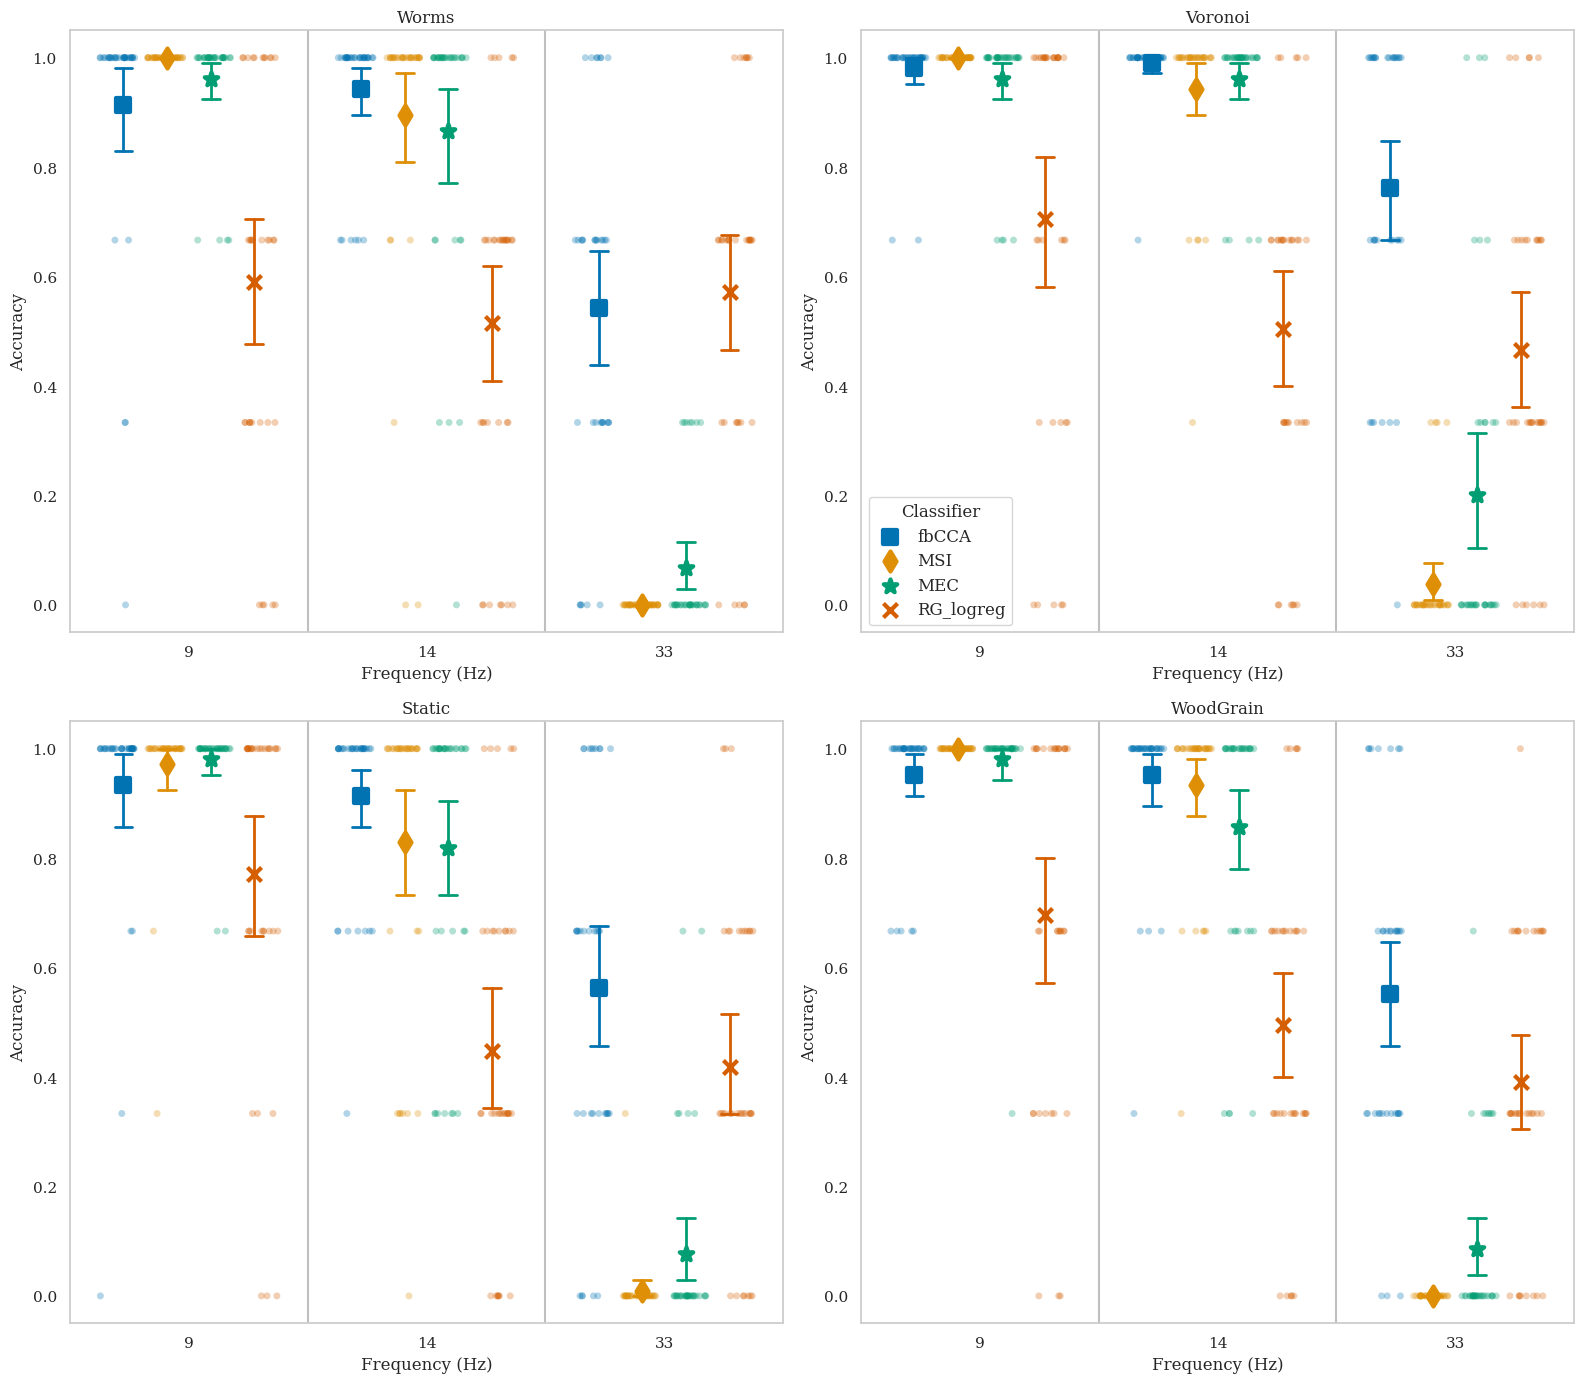

In [5]:
# Melt the dataframe to long format
accuracy_df_long = pd.melt(
    accuracy_df,
    id_vars=['Subject', 'Stimulus'],
    value_vars=['fbCCA-9', 'fbCCA-14', 'fbCCA-33', 'MSI-9', 'MSI-14', 'MSI-33', 'MEC-9', 'MEC-14', 'MEC-33', 'RG_logreg-9', 'RG_logreg-14', 'RG_logreg-33'],
    var_name='Classifier_Freq',
    value_name='Accuracy'
)

# Extract classifier and frequency information
accuracy_df_long['Classifier'] = accuracy_df_long['Classifier_Freq'].apply(lambda x: x.split('-')[0])
accuracy_df_long['Frequency'] = accuracy_df_long['Classifier_Freq'].apply(lambda x: x.split('-')[1])

# Ensure consistency in classifier names
accuracy_df_long['Classifier'] = accuracy_df_long['Classifier'].replace({'RG-logreg': 'RG_logreg'})

# Ensure Frequency is treated as a categorical variable with specific order
accuracy_df_long['Frequency'] = pd.Categorical(accuracy_df_long['Frequency'], categories=['9', '14', '33'], ordered=True)

# Filter for specific stimuli
desired_stimuli = ['Worms', 'Voronoi', 'Static', 'WoodGrain']
filtered_accuracy_df = accuracy_df_long[accuracy_df_long['Stimulus'].isin(desired_stimuli)]

# Create a larger grid of subplots with increased size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a dictionary to store the legend handles and labels
legend_handles = {}

# Define marker types for each classifier
marker_types = {'fbCCA': 'o', 'MSI': 's', 'MEC': '^', 'RG_logreg': 'D'}

# Loop through each stimulus type and create a separate plot in each subplot
for idx, stimulus in enumerate(desired_stimuli):
    # Filter data for the current stimulus
    stimulus_df = filtered_accuracy_df[filtered_accuracy_df['Stimulus'] == stimulus]

    # Create the plot in the corresponding subplot with different markers for each classifier
    sns.pointplot(
        data=stimulus_df, 
        x='Frequency',
        y='Accuracy', 
        hue='Classifier', 
        capsize=0.075, 
        dodge=0.55,
        markers=["s", "d", "*", "x"], 
        ax=axes[idx], 
        scale = 1.5, 
        palette= 'colorblind',
        linestyles = " ",
        errwidth= 2
    )
    
    sns.stripplot(
        data=stimulus_df,
        x='Frequency', 
        y='Accuracy', 
        hue='Classifier', 
        jitter=0.3, 
        dodge= 0.75, 
        alpha=0.3, 
        edgecolor=None, 
        ax=axes[idx],
        palette = 'colorblind'
    )

    axes[idx].axvline(0.50, color='gray', linestyle='-', alpha = 0.5, zorder = 0)
    axes[idx].axvline(1.50, color='gray', linestyle='-', alpha = 0.5, zorder = 0)



    # Get the legend handles and labels for the current plot
    handles, labels = axes[idx].get_legend_handles_labels()

    # Combine legend handles and labels from all plots
    for handle, label in zip(handles, labels):
        if label not in legend_handles:
            legend_handles[label] = handle

    # Adjust labels and title for each subplot
    axes[idx].set_xlabel('Frequency (Hz)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{stimulus}')
    axes[idx].grid(False)

    # Hide legend for all but the bottom right plot
    if idx != 1:
        axes[idx].legend([], [], frameon=False)

# Create legend elements using unique handles and labels
legend_elements = [(legend_handles[label], label) for label in legend_handles]

# Create a legend for the bottom right plot
legend = axes[1].legend(handles=[handle for handle, _ in legend_elements], labels=[label for _, label in legend_elements], title='Classifier', loc='lower left')

# Adjust legend font size
for text in legend.get_texts():
    text.set_fontsize(12)  # Adjust the font size as needed


# Adjust layout
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\admin\Documents\ncan-classifier-validation\Figures\\panel_plot_div_by_freq.svg")


In [7]:
sns.set_style({'font.family': 'Times New Roman'})

# Melt the dataframe to long format without separating by frequency
accuracy_df_long = pd.melt(
    accuracy_df2,
    id_vars=['Subject', 'Stimulus'],
    value_vars=['fbCCA', 'MSI', 'MEC', 'RG_logreg'],
    var_name='Classifier',
    value_name='Accuracy'
)

value_vars=['fbCCA', 'MSI', 'MEC', 'RG_logreg']

# Filter for specific stimuli
desired_stimuli = ['Worms', 'Voronoi', 'Static', 'WoodGrain']
filtered_accuracy_df = accuracy_df_long[accuracy_df_long['Stimulus'].isin(desired_stimuli)]

# Create a larger grid of subplots with increased size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define marker types for each classifier
marker_types = {'fbCCA': 'o', 'MSI': 's', 'MEC': '^', 'RG_logreg': 'D'}
palette = sns.color_palette('dark:black')

# Loop through each stimulus type and create a separate plot in each subplot
for idx, stimulus in enumerate(desired_stimuli):
    # Filter data for the current stimulus
    stimulus_df = filtered_accuracy_df[filtered_accuracy_df['Stimulus'] == stimulus]

    # Plot data for each classifier with different markers
    sns.pointplot(
        data=stimulus_df, 
        x='Classifier',
        y='Accuracy', 
        capsize=0.075, 
        dodge = 0.55,
        markers=["s", "d", "*", "x"], 
        ax=axes[idx], 
        hue = "Classifier",
        scale=1, 
        linestyles=" ",
        errwidth=2,
        palette = 'dark:black'
    )
        
    sns.stripplot(
        data=stimulus_df,
        x='Classifier', 
        y='Accuracy', 
        jitter=0.3, 
        dodge = 0.2,
        alpha=0.3, 
        edgecolor=None, 
        ax=axes[idx],
        palette= 'dark:black'
    )
    

    # Adjust labels and title for each subplot
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'{stimulus}')
    axes[idx].set_ylim(0.1,1.05)

    # Hide legend
    if idx != 4:
        axes[idx].legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\admin\Documents\ncan-classifier-validation\Figures\panel_plot_no_freq.svg")


NameError: name 'accuracy_df2' is not defined

## Sensitivity Bar Plot

C:\Users\admin\AppData\Local\Temp\ipykernel_4640\1106262859.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_4640\1106262859.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_4640\1106262859.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_4640\1106262859.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


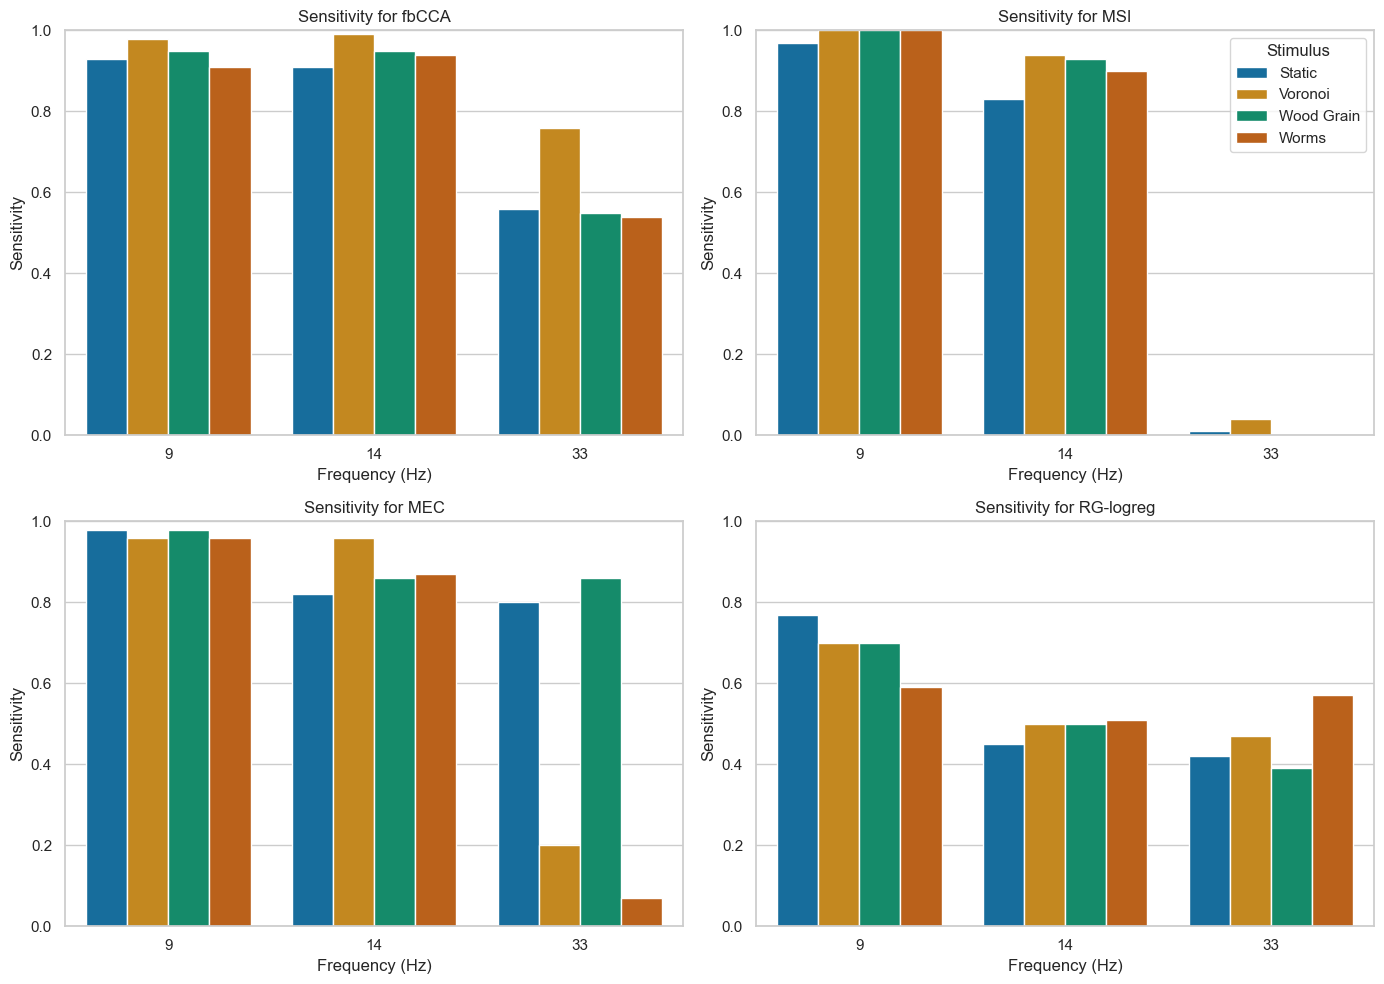

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'your_file.csv' with the actual path to your CSV file
df = pd.read_csv(r'C:\Users\admin\Documents\easy-on-the-eyes\Data\Journal Paper\CA results 8-15\Sensitivity_Long.csv')

# Ensure the data types are correct
df['Frequency'] = df['Frequency'].astype(str)
df['Classifier'] = df['Classifier'].astype(str)
df['Stimulus'] = df['Stimulus'].astype(str)

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# List of classifiers
classifiers = ['fbCCA', 'MSI', 'MEC', 'RG-logreg']

# Plot each classifier's data in its respective subplot
for i, classifier in enumerate(classifiers):
    # Filter data for the current classifier
    data = df[df['Classifier'] == classifier]

    # Create the bar plot
    sns.barplot(
        x='Frequency',
        y='Sensitivity_Mean',
        hue='Stimulus',
        data=data,
        ax=axs[i],
        ci='sd',
        palette='colorblind',
        capsize=.1
    )
    
    axs[i].set_ylim(0, 1)
    axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    # Add titles and labels
    axs[i].set_title(f'Sensitivity for {classifier}')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Sensitivity')

    
    # Remove legend from all but the top right plot
    if i != 1:  # Keep legend only in the second subplot (top right)
        axs[i].get_legend().remove()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
